# Categorize Communities and Sentiment Clusters

In [1]:
import pprint
import json
import pathlib
import pandas as pd
import os
import importlib
import networkx as nx
import matplotlib.pyplot as plt
import math
from random import sample
from collections import Counter

In [2]:
from libWill.helpers import *
pp = pprint.PrettyPrinter(indent=4)

### Function to Load Twitter Sentiment Data as Pandas Data Frame

In [3]:
def twitter_premium_as_df(clean_data_path):
    """something like '../../data/clean/' maybe? """
    def listdir_fullpath(d):
        """Function in a functions, whaaaa??!!?!"""
        return [os.path.join(d, f) for f in os.listdir(d)]
    
    clean_data = pathlib.Path(clean_data_path)
    pickles = os.listdir(clean_data)
    full_pickles = listdir_fullpath(clean_data)
    # But this function is doing too much!!
    # Boo hoo 
    return pd.concat([pd.read_pickle(fp) for fp in full_pickles], ignore_index=True)

In [4]:
%time df = twitter_premium_as_df('../../../data/clean/')

CPU times: user 1.74 s, sys: 323 ms, total: 2.06 s
Wall time: 2.06 s


In [7]:
df = df[['created_at','screen_name','full_text','id','lang','mention_ids','mentions','rt_status_id','rt_status_screen_name']]

In [8]:
df.head(2)

created_at      screen_name  \
0 2019-10-31 23:58:56+00:00       Ricky_P007   
1 2019-10-31 23:58:56+00:00  KennedyPattiso1   

                                           full_text                   id  \
0  RT @Delta_Exchange: How many coin logos do you...  1190055587255422977   
1  RT @XRPcryptowolf: Intercontinental Exchange (...  1190055584910991360   

  lang           mention_ids          mentions        rt_status_id  \
0   en  [994891951160864769]  [Delta_Exchange]  994891951160864769   
1   en  [944462285573099520]   [XRPcryptowolf]  944462285573099520   

  rt_status_screen_name  
0        Delta_Exchange  
1         XRPcryptowolf

In [9]:
df_network = df[['screen_name','mentions','rt_status_screen_name']]
df_network.head()

screen_name                                           mentions  \
0       Ricky_P007                                   [Delta_Exchange]   
1  KennedyPattiso1                                    [XRPcryptowolf]   
2      BtcEthereum                                                 []   
3    erickchan_XLM  [CyhChloe, johnkim77, jasminecoin, codeyisfun,...   
4     Researchiing                                        [zerohedge]   

  rt_status_screen_name  
0        Delta_Exchange  
1         XRPcryptowolf  
2                   NaN  
3                   NaN  
4             zerohedge

In [10]:
smallnet = df_network
smallnet.tail()

screen_name           mentions rt_status_screen_name
203995         creep2oo  [ConversationEDU]                   NaN
203996    humble_crypto  [Bitcoin_Vending]                   NaN
203997    Tylerderden23        [hodlonaut]             hodlonaut
203998    Tylerderden23        [hodlonaut]             hodlonaut
203999  FrancesMcIntos1   [VladoBotsvadze]        VladoBotsvadze

##Unpacking the mentions column to have multiple rows for each item in the mentions list

In [11]:
smallnet_exploded = smallnet.explode('mentions')

In [12]:
smallnet_exploded

screen_name         mentions rt_status_screen_name
0            Ricky_P007   Delta_Exchange        Delta_Exchange
1       KennedyPattiso1    XRPcryptowolf         XRPcryptowolf
2           BtcEthereum              NaN                   NaN
3         erickchan_XLM         CyhChloe                   NaN
3         erickchan_XLM        johnkim77                   NaN
...                 ...              ...                   ...
203995         creep2oo  ConversationEDU                   NaN
203996    humble_crypto  Bitcoin_Vending                   NaN
203997    Tylerderden23        hodlonaut             hodlonaut
203998    Tylerderden23        hodlonaut             hodlonaut
203999  FrancesMcIntos1   VladoBotsvadze        VladoBotsvadze

[260677 rows x 3 columns]

In [13]:
smallnet_exploded.reset_index(inplace=True,drop=True)

In [14]:
smallnet_exploded.tail()

screen_name         mentions rt_status_screen_name
260672         creep2oo  ConversationEDU                   NaN
260673    humble_crypto  Bitcoin_Vending                   NaN
260674    Tylerderden23        hodlonaut             hodlonaut
260675    Tylerderden23        hodlonaut             hodlonaut
260676  FrancesMcIntos1   VladoBotsvadze        VladoBotsvadze

In [15]:
edges = list(zip(smallnet_exploded['screen_name'],smallnet_exploded['mentions']))

In [16]:
len(edges)

260677

In [17]:
display(edges[1904],
edges[1905])

('tsotsoobilove', 'XrpMr')

('tsotsoobilove', 'cryptopolis_x')

In [18]:
edges = [t for t in edges if not any(isinstance(n, float) and math.isnan(n) for n in t)]

In [19]:
len(edges)

190634

In [20]:
#print(edges)

In [21]:
twit_graph = nx.Graph()

In [22]:
twit_graph.add_nodes_from(smallnet['screen_name'])

In [23]:
twit_graph.add_edges_from(edges)

In [24]:
import community
parts = community.best_partition(twit_graph)
values = [parts.get(node) for node in twit_graph.nodes()]

In [25]:
node_list = list(twit_graph.nodes())
community_dict = { n:c for n,c in zip(node_list,values)}
nx.set_node_attributes(twit_graph, community_dict, 'community')

In [26]:
screen_name_list = df['screen_name'].tolist()

In [27]:
# community_df_column = {}
# for key,value in community_dict.items():
#         if key in df['screen_name'].tolist():
#             df['community'] = value
            

In [28]:
df["community"] = df["screen_name"].map(community_dict)

In [29]:
df.tail(2)

created_at      screen_name  \
203998 2019-10-27 21:41:47+00:00    Tylerderden23   
203999 2019-10-27 21:41:46+00:00  FrancesMcIntos1   

                                                full_text  \
203998  RT @hodlonaut: Bitcoin, you're not fooling any...   
203999  RT @VladoBotsvadze: Amazon has almost no store...   

                         id lang           mention_ids          mentions  \
203998  1188571519842209792   en  [852259884175372290]       [hodlonaut]   
203999  1188571515119439872   en           [373883201]  [VladoBotsvadze]   

              rt_status_id rt_status_screen_name  community  
203998  852259884175372290             hodlonaut         27  
203999           373883201        VladoBotsvadze        113

In [30]:
nx.number_of_nodes(twit_graph)

82190

In [31]:
nx.number_of_edges(twit_graph)

145317

In [32]:
#

In [33]:
# drop_nodes = []
# for i in twit_graph.nodes:
#     if twit_graph.degree(i) < 3:
#         drop_nodes.append(i)

In [34]:
#twit_graph.remove_nodes_from(drop_nodes)

In [35]:
nx.number_of_nodes(twit_graph)

82190

In [36]:
import community
parts = community.best_partition(twit_graph)
values = [parts.get(node) for node in twit_graph.nodes()]

In [37]:
print(community.__version__)

0.13


In [38]:
#! dir C:\Users\mferb\Anaconda3\envs\project2\lib\site-packages\community

In [39]:
#! conda list community

In [40]:
node_list = list(twit_graph.nodes())
community_dict = { n:c for n,c in zip(node_list,values)}
nx.set_node_attributes(twit_graph, community_dict, 'community')

In [41]:
from bokeh.io import show, save, output_file 
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, BoxZoomTool, ResetTool
from bokeh.models.graphs import from_networkx
from bokeh.palettes import Spectral8
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
import holoviews as hv


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
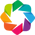

In [42]:
hv.extension('bokeh')

In [43]:

import random
sizes = [random.randrange(8, 20, 1) for i in range(nx.number_of_nodes(twit_graph))]

```
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
g.add_edges_from([(1,2), (2,3), (2,4), (3,4)])

d = nx.degree(g)

nx.draw(g, nodelist=d.keys(), node_size=[v * 100 for v in d.values()])
plt.show()
```

In [ ]:
%opts Graph [width=1200 height=800]
padding = dict(x=(-1.1, 1.1), y=(-1.1, 1.1))
#cmap=plt.cm.Blues
#[v * 100 for v in d.values()]
# g = nx.Graph(twit_graph)
# d = dict(twit_graph.degree()).values()
# sorta worked # hv.dim('size')*20
%time twitter_graph = hv.Graph.from_networkx(twit_graph, nx.layout.spring_layout)\
                .redim.range(**padding)\
                .options(color_index='community',node_alpha=0.5, node_size=20,edge_line_width=1,edge_line_color='black',cmap='Category20', colorbar=True, axiswise=True)
#hv.save(twitter_graph, 'holoview_kamada_layout.html')                                        
#hv.save(Graph, 'holoview_test.html')

In [ ]:
twitter_graph

In [110]:
%opts Graph [width=1200 height=900]
padding = dict(x=(-1.1, 1.1), y=(-1.1, 1.1))
#cmap=plt.cm.Blues
#[v * 100 for v in d.values()]
# g = nx.Graph(twit_graph)
# d = dict(twit_graph.degree()).values()
# kwargs={'weight': 'weight'}
%time twitter_circ_graph = hv.Graph.from_networkx(twit_graph, nx.layout.fruchterman_reingold_layout,)\
                .redim.range(**padding)\
                .options(color_index='community',node_alpha=0.5, node_size=20,edge_line_width=1,edge_line_color='#333333',cmap='Category20', colorbar=True, axiswise=True)
#hv.save(twitter_graph, 'holoview_kamada_layout.html')                                        
#hv.save(Graph, 'holoview_test.html')

CPU times: user 19.8 s, sys: 0 ns, total: 19.8 s
Wall time: 19.9 s


In [111]:
twitter_circ_graph

:Graph   [start,end]

In [434]:
# #hover = HoverTool(tooltips=[('screen_name', twit_graph.nodes)])
                  
# plot = figure(title="5000 Tweets Test",
#               width=800,height=600,
#               tools=['box_zoom','pan','wheel_zoom','reset'], x_range=(-1.1,1.1), y_range=(-1.1,1.1))

# graph = from_networkx(twit_graph, nx.spring_layout, scale=3, center=(0,0))
# # graph.node_renderer.data_source = values

# graph.node_renderer.data_source.data['community'] = [i[1]['community'] for i in twit_graph.nodes(data=True)]
# graph.node_renderer.glyph = Circle(
#     size=10, 
#     fill_color=linear_cmap('community', 'Spectral8', 0, len(twit_graph.nodes()))
# )

# plot.renderers.append(graph)

# #output_file("5000_tweet_test_community.html")
# show(plot)

In [507]:
from holoviews.operation.datashader import datashade, bundle_graph


In [540]:
bundled = bundle_graph(twitter_graph)
bundled

:Graph   [start,end]

:Graph   [start,end]

In [625]:
sorted(twit_graph.degree, key=lambda x: x[1], reverse=True)

[('APompliano', 80),
 ('Rhythmtrader', 65),
 ('realDonaldTrump', 36),
 ('CalvinAyre', 31),
 ('TheCryptoconomy', 30),
 ('Bitcoin_Beyond', 29),
 ('Cointelegraph', 28),
 ('saifedean', 27),
 ('Xentagz', 25),
 ('coindesk', 24),
 ('DesiCryptoHodlr', 23),
 ('pierre_rochard', 22),
 ('bitcoin_clara', 22),
 ('Twanomatic2', 20),
 ('kurtwuckertjr', 19),
 ('bitcoin_ug', 19),
 ('lopp', 19),
 ('NIXwhale', 19),
 ('ErikVoorhees', 19),
 ('Bitboy_Crypto', 19),
 ('aantonop', 19),
 ('CoinstorageGuru', 18),
 ('danheld', 18),
 ('Ragnarly', 18),
 ('american_hodl', 18),
 ('alistairmilne', 18),
 ('Bitcoin', 18),
 ('MichellePhan', 18),
 ('PeterSchiff', 18),
 ('Emperor_YZ', 17),
 ('Josh_Rager', 17),
 ('Poetry4Bitcoin', 17),
 ('dergigi', 17),
 ('Hermetec', 17),
 ('_blockandchain_', 17),
 ('bitstein', 17),
 ('TuurDemeester', 17),
 ('HotepJesus', 17),
 ('Capfolio', 17),
 ('EntangleIT', 16),
 ('eternalcrypto1', 16),
 ('Bitcoin_org_', 15),
 ('JimmyNLose', 15),
 ('_omohoje', 15),
 ('M_ednut', 15),
 ('johnkim77', 15),
 

In [163]:
community = nx.get_node_attributes(twit_graph,'Community')

In [175]:
largest_community = Counter(community['Bitcoin'])
largest_community.most_common()

[(8, 97),
 (30, 94),
 (7, 84),
 (5, 75),
 (112, 72),
 (0, 71),
 (3, 70),
 (27, 67),
 (60, 67),
 (21, 62),
 (24, 62),
 (35, 58),
 (57, 56),
 (31, 52),
 (9, 50),
 (14, 48),
 (205, 43),
 (12, 40),
 (33, 35),
 (74, 31),
 (11, 25),
 (278, 23),
 (22, 22),
 (37, 19),
 (64, 17),
 (130, 16),
 (1, 14),
 (15, 12),
 (18, 12),
 (125, 12),
 (56, 10),
 (114, 9),
 (174, 9),
 (299, 9),
 (2, 8),
 (50, 8),
 (13, 7),
 (29, 7),
 (49, 7),
 (68, 7),
 (106, 7),
 (163, 7),
 (190, 7),
 (281, 7),
 (372, 7),
 (23, 6),
 (48, 6),
 (66, 6),
 (71, 6),
 (72, 6),
 (113, 6),
 (135, 6),
 (176, 6),
 (244, 6),
 (266, 6),
 (331, 6),
 (19, 5),
 (20, 5),
 (26, 5),
 (38, 5),
 (42, 5),
 (46, 5),
 (53, 5),
 (54, 5),
 (69, 5),
 (93, 5),
 (103, 5),
 (120, 5),
 (122, 5),
 (133, 5),
 (151, 5),
 (154, 5),
 (184, 5),
 (294, 5),
 (459, 5),
 (4, 4),
 (16, 4),
 (36, 4),
 (39, 4),
 (45, 4),
 (67, 4),
 (83, 4),
 (85, 4),
 (91, 4),
 (126, 4),
 (138, 4),
 (139, 4),
 (140, 4),
 (149, 4),
 (159, 4),
 (167, 4),
 (180, 4),
 (197, 4),
 (204, 4),


In [178]:
print(len(community['Bitcoin']))

2632


In [176]:
nodes = list(twit_graph.nodes)

In [182]:
print(nodes[3])

Techcenterr


In [36]:
isolates = nx.isolates(twit_graph)

In [38]:
list(isolates)

['BtcEthereum',
 'RockstaTrading',
 'squatch_crypto',
 'FinTechNames',
 'PatriotCrypto',
 'BitBullCapital',
 'duniajalanjalan',
 'Etherbankingita',
 'Franzferdinan57',
 'ICOResearchGRP',
 'SportsbookBTC',
 'BitcoinCatz',
 'Crypt0Constella',
 'VoCtpgC8Ki241Rg',
 'KriptoKanalim',
 'webnowcompany',
 'coinbureau',
 'mospretmen',
 'ALTcoin_Ninjas',
 'bitlyfool',
 'retiredin2016',
 'HashDeploy',
 'TheeSeanH',
 'Lobaoal',
 'ShillHater',
 'ib_cpa',
 'AntonioSerbia',
 'SnowflakesAwwww',
 'Blacktradelines',
 'cryptogarten',
 'crypto__mak',
 'jadwahab',
 'HydaxE',
 'coinsonnews',
 'BizSoftwareEdu',
 'thecryptorep',
 'Ursalacher',
 'AinslieWealth',
 'TheSh0tC4ll3r',
 'InvestForward18',
 'icoinmarket1',
 'dragonwolftech',
 'robertdolci',
 'NachoThome',
 'DarkNodeGuru',
 'foxesden34',
 'BigCheds',
 'help_me_plzplz_',
 'News_1jl4',
 'Teokanistras',
 'PaulESamson',
 'AvyLorenCohen',
 'grbroker',
 'Cryptonetwealth',
 'GetCoinJar',
 'URBitcoinwear',
 'blockchainoshi',
 'bitcoin_jar',
 'FreeCryptoDeals',

In [71]:
twit_graph.remove_nodes_from(list(nx.isolates(twit_graph)))

In [72]:
nx.number_of_nodes(twit_graph)

3156

[('APompliano', 84),
 ('Rhythmtrader', 54),
 ('Cointelegraph', 38),
 ('jack', 29),
 ('100trillionUSD', 26),
 ('Bitcoin', 22),
 ('PeterSchiff', 21),
 ('qhfofficial', 20),
 ('BitCoin_Invest_', 20),
 ('Poetry4Bitcoin', 17),
 ('coindesk', 16),
 ('Hermetec', 16),
 ('Satoshis_D', 15),
 ('SammarA12281909', 13),
 ('Bitcoin_Beyond', 13),
 ('codeyisfun', 12),
 ('CalvinAyre', 11),
 ('TheCryptoconomy', 11),
 ('popesta', 11),
 ('realDonaldTrump', 11),
 ('Bakkt', 11),
 ('PeterMcCormack', 11),
 ('american_hodl', 11),
 ('CryptoOz', 10),
 ('Hanakookie1', 10),
 ('NemesisBSV', 10),
 ('Cripto_Bitcoin', 10),
 ('BTCTN', 10),
 ('StormIsUponUs', 10),
 ('ibmlahamad', 9),
 ('BitcoinEcon', 9),
 ('Coinicarus', 9),
 ('YobitsVision', 9),
 ('LomahCrypto', 9),
 ('Mihalbig', 9),
 ('Xentagz', 9),
 ('MZietzke', 9),
 ('Anders_', 9),
 ('trylolli', 9),
 ('HotepJesus', 9),
 ('HonorAfricans', 9),
 ('theonevortex', 8),
 ('InvestCrypForex', 8),
 ('Emperor_YZ', 8),
 ('channelBSV', 8),
 ('mindstatex', 8),
 ('pierre_rochard', 8),

In [85]:
nx.average_degree_connectivity(twit_graph)

{1: 6.369631236442516,
 3: 3.8732943469785575,
 2: 7.258947368421053,
 4: 4.375,
 9: 4.981481481481482,
 6: 2.8015873015873014,
 8: 3.46875,
 5: 2.9348837209302325,
 7: 4.333333333333333,
 84: 3.0357142857142856,
 11: 3.9220779220779223,
 10: 3.8333333333333335,
 13: 6.230769230769231,
 16: 2.875,
 15: 4.8,
 21: 6.761904761904762,
 17: 5.823529411764706,
 38: 1.9210526315789473,
 54: 1.5740740740740742,
 29: 2.0,
 22: 3.3181818181818183,
 20: 1.025,
 12: 1.8333333333333333,
 26: 2.923076923076923}

In [93]:
edges_for_node_x = twit_graph.degree('Rhythmtrader')

In [94]:
print(edges_for_node_x)

54


In [100]:
print(len(drop_nodes))

2780


In [1]:
print(len(community_dict))

NameError: name 'community_dict' is not defined